In [2]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from modules.Utils.utils import loadFromDB, strategyTester
from modules.Utils.indicators import computeSuperTrend, addIndicators, computeLaggingLinearRegression, computeTrixIndicator, generateDatesFeatures

import pandas as pd

import warnings 
warnings.filterwarnings('ignore')
from random import randint

from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
from bokeh.layouts import row, column
output_notebook()


Loading BokehJS ...

#  Importing Data

In [5]:
SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'1d')
df.dropna(inplace=True)
print(df.shape)
df.head()

(849, 6)


,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2020-06-01,9448.27,10380.00,9421.67,10200.77,76649.126960,1590969600
2020-06-02,10202.71,10228.99,9266.00,9518.04,108970.773151,1591056000
2020-06-03,9518.02,9690.00,9365.21,9666.24,46252.644939,1591142400
2020-06-04,9666.32,9881.63,9450.00,9789.06,57456.100969,1591228800
2020-06-05,9788.14,9854.75,9581.00,9621.16,47788.050050,1591315200


# Monte Carlo

                        Close
Date                         
2020-01-01 01:00:00  0.232773
2020-01-01 02:00:00  0.234046
2020-01-01 03:00:00  0.234908
2020-01-01 04:00:00  0.234329
2020-01-01 05:00:00  0.234078
...                       ...
2022-09-15 10:00:00  0.653504
2022-09-15 11:00:00  0.652956
2022-09-15 12:00:00  0.653712
2022-09-15 13:00:00  0.653473
2022-09-15 14:00:00  0.653599

[23694 rows x 1 columns]


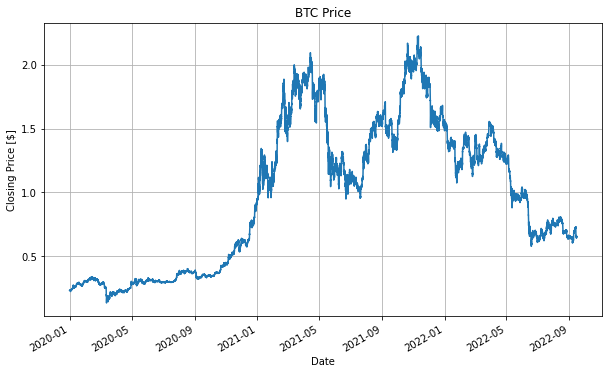

In [6]:
# Pulling Closing Price Data
hist = df[['Close']]
print(hist)

# Plotting Price Data
hist['Close'].plot(title=f"{SYMBOL} Price", ylabel=
                   "Closing Price [$]", figsize=[10, 6])
plt.grid()

In [329]:
days = [i for i in range(1, len(hist['Close'])+1)]
price_orig = hist['Close'].tolist()
change = hist['Close'].pct_change().tolist()
change = change[1:]  # Removing the first term since it is NaN

# Statistics for Use in Model
mean = np.mean(change)
std_dev = np.std(change)
print('\nMean percent change: ' + str(round(mean*100, 2)) + '%')
print('Standard Deviation of percent change: ' +   
      str(round(std_dev*100, 2)) + '%')


Mean percent change: 0.23%
Standard Deviation of percent change: 4.01%


Predicted closing price after 400 simulations: 31258.04 USDT
Predicted percent increase after 6 hours: 0.78 %
Probability of stock price increasing after 6 hours: 52.0 %


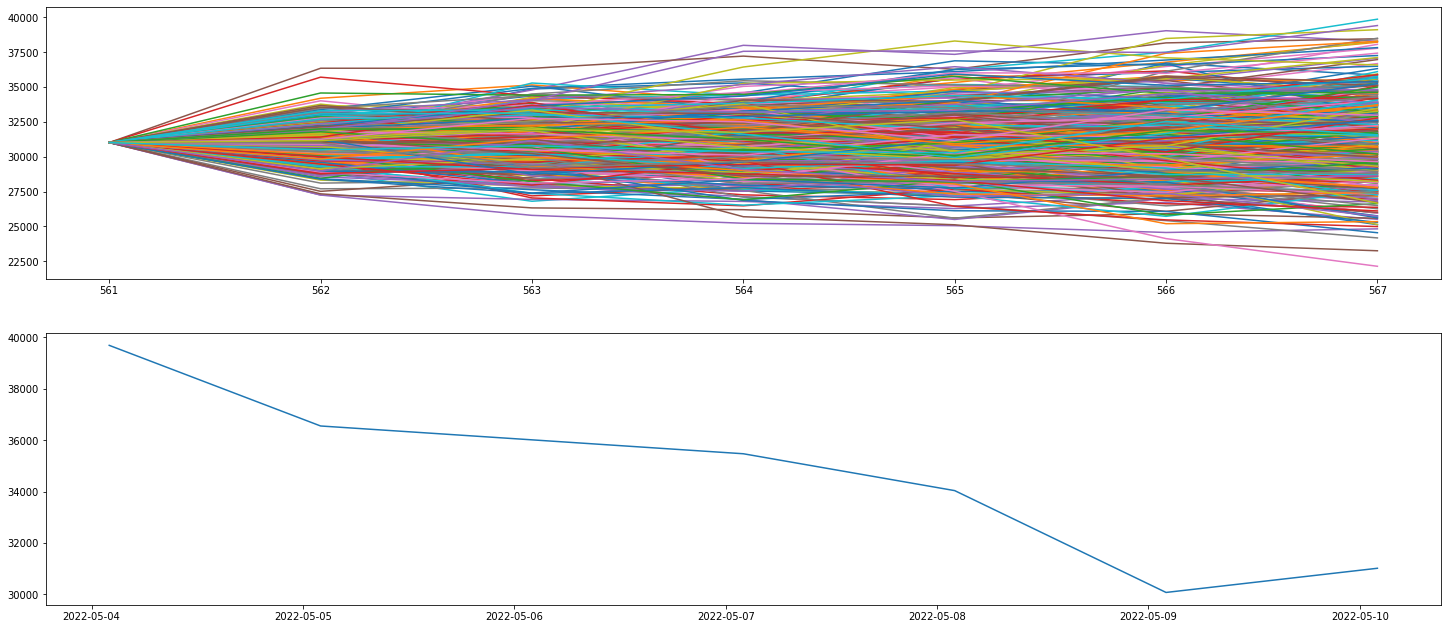

In [330]:
fig, ax = plt.subplots(2, figsize=(25,11))

# Initializing Lists for Analysis
close_end = []
above_close = []

simulations = 400# Change for more results
days_to_sim = 6 # 10 days


# For Loop for Number of Simulations Desired
for i in range(simulations):
    num_days = [days[-1]]
    close_price = [hist.iloc[-1, 0]]
    
    # For Loop for Number of Days to Predict
    for j in range(days_to_sim):
        num_days.append(num_days[-1]+1)
        perc_change = norm.ppf(random(), loc=mean, scale=std_dev)
        close_price.append(close_price[-1]*(1+perc_change))

    if close_price[-1] > price_orig[-1]:
        above_close.append(1)
    else:
        above_close.append(0)

    close_end.append(close_price[-1])
    ax[0].plot(num_days, close_price)
    
# Average Closing Price and Probability of Increasing After 1 Year
average_closing_price = sum(close_end)/simulations
average_perc_change = (average_closing_price-price_orig[-1])/price_orig[-1]
probability_of_increase = sum(above_close)/simulations

print(f'Predicted closing price after {simulations} simulations: {round(average_closing_price, 2)} USDT')
print(f'Predicted percent increase after {days_to_sim} hours: {round(average_perc_change*100, 2)} %')
print(f'Probability of stock price increasing after {days_to_sim} hours: {round(probability_of_increase*100, 2)} %')

ax[1].plot(df.Close.iloc[-1-days_to_sim:].index, df.Close.iloc[-1-days_to_sim:], label='Real')


# Black Scholes Merton

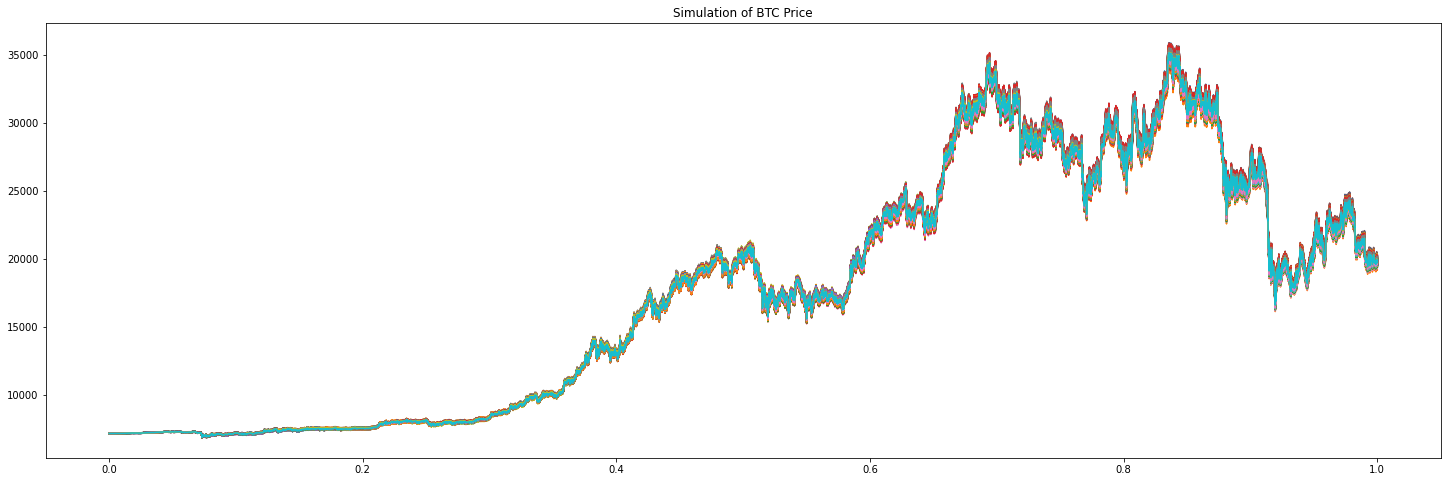

In [47]:
plt.figure(figsize=(25,8))
T = len(df.Close)
dt = 1.0/T
t = np.arange(dt,1+dt,dt)
lr = np.log(df.Close/df.Close.shift(1))
mu = lr.cumsum()
sigma = [lr[:x].std() for x in range (1,len(lr)+1)] # standard devation by step
X0 = df.Close[0] # our first term
Y = []

for i in range(10**3) :
    dB = np.sqrt (dt) * np.random.randn(T) #change in brownian motion                                            
    B = np.cumsum(dB) # brownian motion
    y = [ X0 * np.exp((mu[x]-0.5*sigma[x]**2)*t[x]+sigma[x]*B[x]) for x in range (len(mu))]
    plt.plot(t , y )
    plt.title(f'Simulation of {SYMBOL} Price')
    Y.append(y)

In [48]:
df_simu = pd.DataFrame(Y)
df['Prediction'] = [df_simu[col].mean() for col in df_simu.columns]
df.head()

,Open,High,Low,Close,Volume,Timestamp,Prediction
Date,,,,,,,
2020-01-01 01:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,1577836800,NaN
2020-01-01 02:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,1577840400,NaN
2020-01-01 03:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,1577844000,7177.029744
2020-01-01 04:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,1577847600,7177.028652
2020-01-01 05:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,1577851200,7177.025684


In [49]:
p = figure(title=f"Comparaison",x_axis_label='time', y_axis_label='value ($)',x_axis_type='datetime',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
    ("Date", "$x{%F}"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(df.index, df.Close, legend_label="Prediction", line_width=2, color='orange')
p.line(df.index, df.Prediction, legend_label="Deterministic", line_width=2, )

p.legend.location = "top_left"

show(p)

# Other montcarlo

simulation mean: 20344.97
simulation max: 63308.56
simulation min: 7706.42
simulation std: 3093.68


18673.22334090134

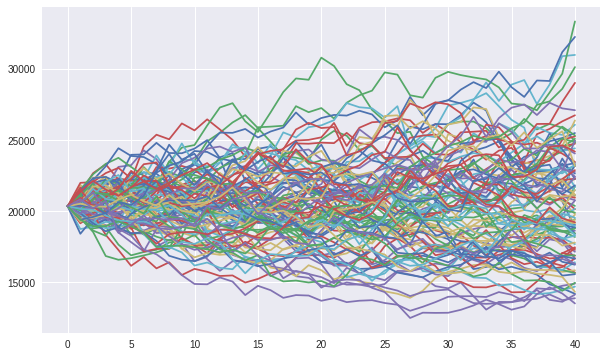

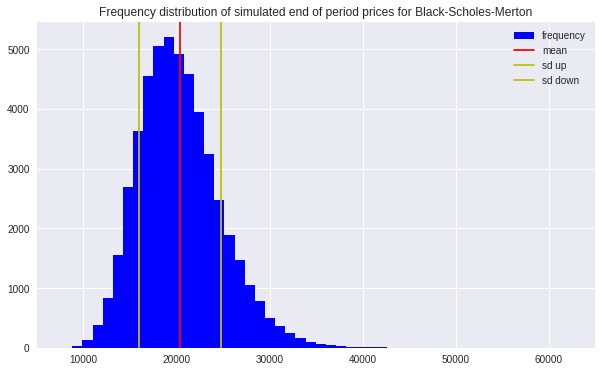

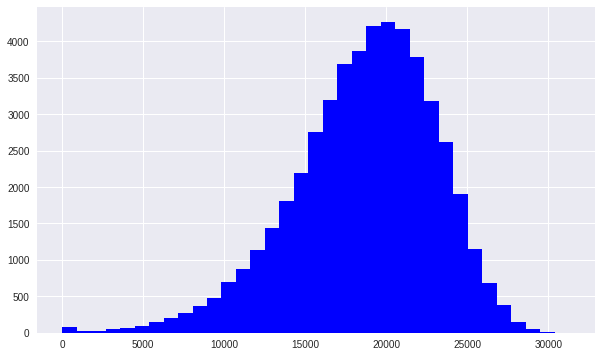

In [11]:
import numpy as np
from pylab import plt
from datetime import datetime
import datetime as dt
from modules.Utils.utils import loadFromDB
plt.style.use('seaborn')

day_in_future = 40

df_data = loadFromDB('BTC','1d',False).iloc[-day_in_future:]

# define model paramaters------------------------------------------------------
S0 = df_data['Close'][-1] # initial price
K = 39000 # option strike price
r = 0.006 # 1-year treasury rate from https://ycharts.com/indicators/1_year_treasury_rate
T = day_in_future/365 # time horizon and option maturity (in years)
sigma = df_data['Close'].pct_change().dropna().std() * np.sqrt(365) # constant volatility factor

# Monte Carlo simulation parameters
M = day_in_future # paths (trading days)
I = 50000 # number of simulations
dt = T / M # length of time interval
df = np.exp(-r * dt) # discount factor for single time interval

# generate two-dimensional random numbers using standard normal distribution
rn = np.random.standard_normal((M + 1, I))

# generate object of same shape as rn   
S = np.zeros_like(rn)
S[0] = S0 # latest price used in first row (simulation start)

# single price paths are simulated based on the initial price, 
# the random number matrix and the difference equation for the geometric Brownian motion
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t])

# examine 100 price paths 
plt.figure(figsize=(10, 6))
plt.plot(S[:, :100]);

# simulation statistics
print('simulation mean: {:.2f}'.format(S.mean()))
print('simulation max: {:.2f}'.format(S.max()))
print('simulation min: {:.2f}'.format(S.min()))
print('simulation std: {:.2f}'.format(S.std()))

# Frequency distribution of simulated end of period prices for Black-Scholes-Merton
ST = S[-1] # ending sim values
plt.figure(figsize=(10, 6))
plt.title('Frequency distribution of simulated end of period prices for Black-Scholes-Merton')
plt.hist(ST, bins=50, color='b', label='frequency');
plt.axvline(ST.mean(), color='r', label='mean')
plt.axvline(ST.mean() + ST.std(), color='y', label='sd up')
plt.axvline(ST.mean() - ST.std(), color='y', label='sd down')
plt.legend(loc=0);

# Frequency distribution of simulated inner values at maturity for the European put option
h = np.maximum(K - ST, 0)
plt.figure(figsize=(10, 6))
plt.hist(h, color='b',  bins=35);

len(h[h == 0]) / len(h) # % of simulations where option expired worthless 

np.exp(-r * T) * h.mean()

# Monte Carlo Valuation of an American Put Option
h = np.maximum(K - S, 0) # inner values over the complete price path (not ST)

# Least-Squares Monte Carlo Valuation (LSM algorithm)--------------------------
V = h[-1]  # sets the initial simulated American option price values to the inner values at maturity
for t in range(M - 1, 0, -1):  # the algorithm works based on backwards induction
    # continuation values are estimated based on the OLS regression 
    # of the present simulated option values against the price levels
    reg = np.polyfit(S[t], df * V, deg=5)  
    C = np.polyval(reg, S[t])  
    # If the inner value is higher than the estimated (approximated) continuation 
    # value, exercise takes place and otherwise not
    V = np.where(h[t] > C, h[t], df * V)  

# present value is calculated as the average over the American option price vector 
# at t=Δt as derived based on the LSM algorithm and discounted for the last remaining 
# time interval to the present t=0
df * V.mean() 

# P-Hacking

(14000, 6)


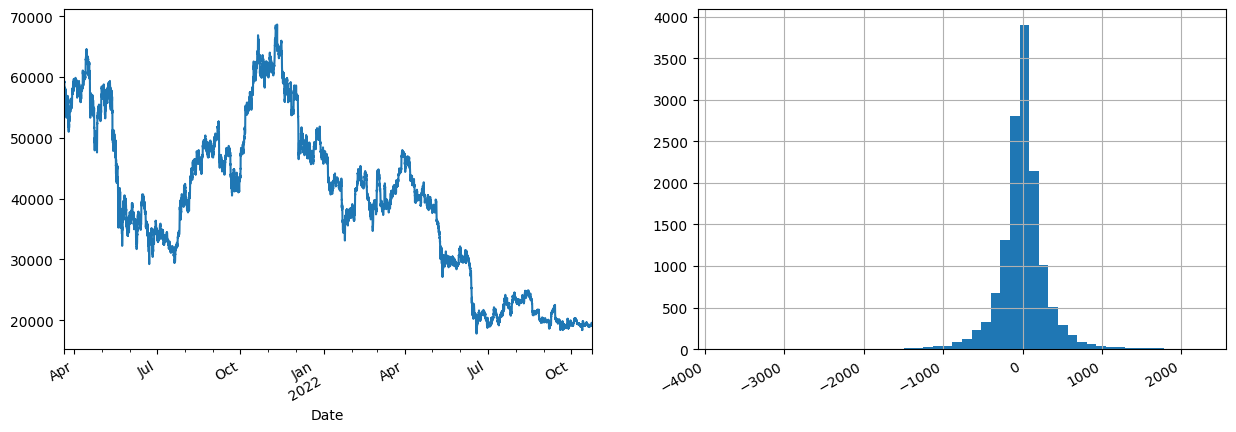

In [49]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'1h').iloc[-14000:]
print(df.shape)


cutoff = len(df)//2
prices = pd.Series(df.Close)
log_prices = np.log(prices)
deltas = pd.Series(np.diff(prices), index=df.index[1:])
log_deltas = pd.Series(np.diff(log_prices), index=df.index[1:])
latest_prices = df.Close#[cutoff:]
latest_log_prices = np.log(latest_prices)
latest_log_deltas = deltas#[cutoff:]
prior_log_deltas = log_deltas#[:cutoff]
prior_log_mean = np.mean(prior_log_deltas)
prior_log_std = np.std(prior_log_deltas)
f, axes = plt.subplots(ncols=2, figsize=(15,5))
prices.plot(ax=axes[0])
deltas.hist(bins=50, ax=axes[1])
f.autofmt_xdate()

In [50]:
def predict(mean, std, size, seed=None):
    """ Returns a normal distribution based on given mean, standard deviation and size"""
    np.random.seed(seed)
    return np.random.normal(loc=mean, scale=std, size=size)

def apply_returns(start, returns):
    """ Applies given periodic returns """
    cur = start
    prices = [start]
    for r in returns:
        cur += r
        prices.append(cur)
    return prices

def score(actual, prediction):
    # mean square error
    return np.mean(np.square(actual - prediction))

def compare(prediction, actual):
    # plots a prediction over the actual series
    plt.figure(figsize=(25,8))
    plt.plot(prediction, label="prediction")
    plt.plot(actual, label="actual")
    plt.legend()

MSE: 1.36735109


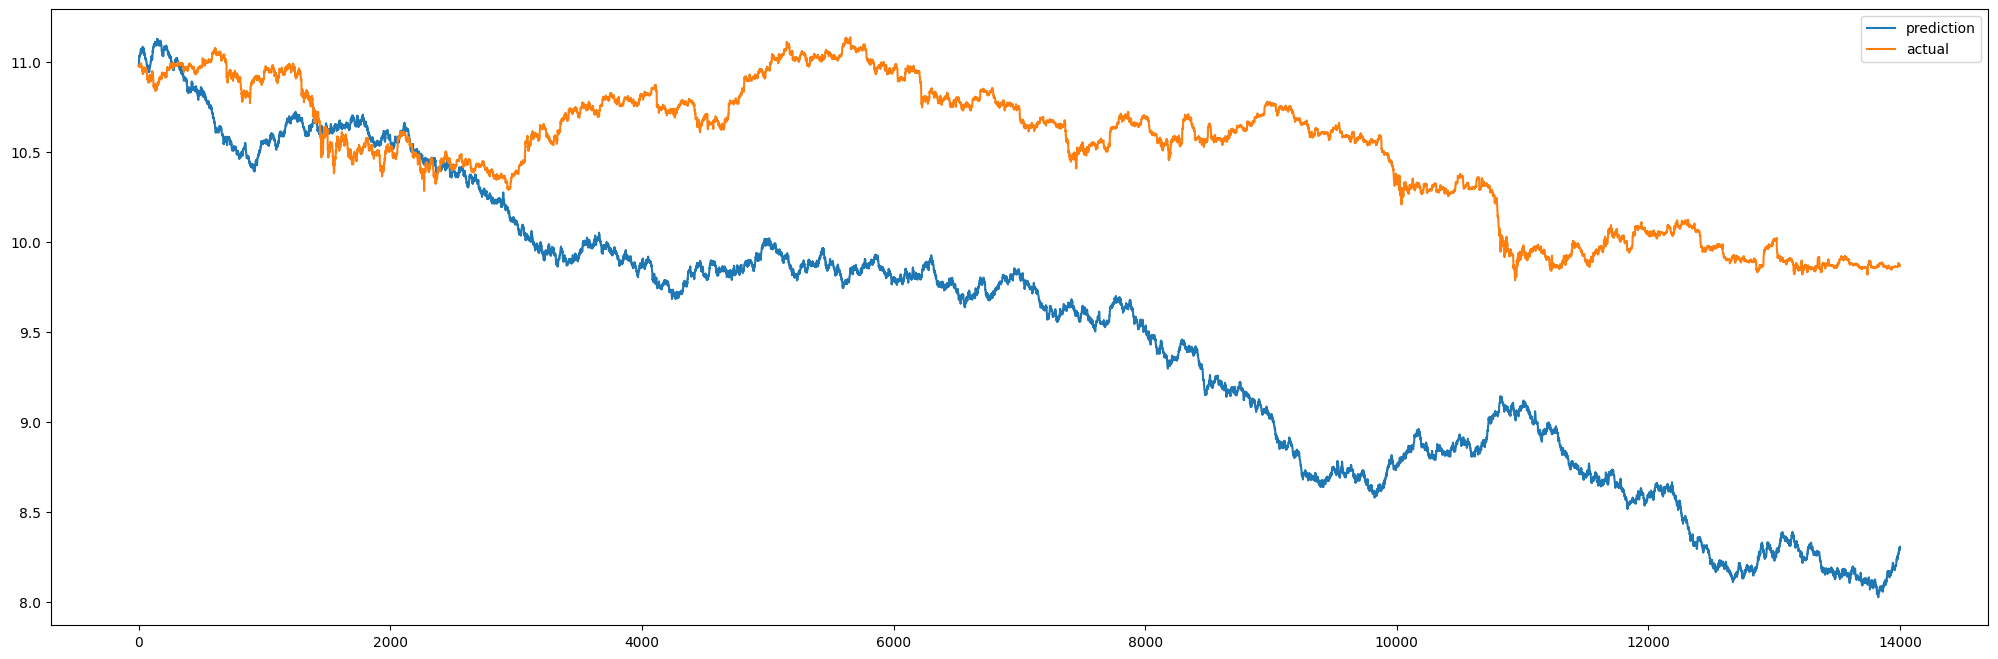

In [51]:
latest_size = len(latest_log_prices)
predict_deltas = predict(prior_log_mean, prior_log_std, latest_size, seed = 0)
start = latest_log_prices[0]
prediction = apply_returns(start, predict_deltas)
print("MSE: {:0.08f}".format(score(latest_log_prices, prediction[:-1])))
compare(prediction=prediction, actual=latest_log_prices.values)

In [57]:
predict_partial = lambda s: predict(mean = prior_log_mean, std =prior_log_std, size = latest_size, seed = s)
def find_best_seed(actual, predict_partial, score, start_seed, end_seed):
    best_so_far = None
    best_score = float("inf")
    start = actual[0]
    for s in range(start_seed, end_seed):
        print('\r{} / {}'.format(s, end_seed), end="")
        predict_deltas = predict_partial(s)
        predict_prices = apply_returns(start, predict_deltas)
        predict_score = score(actual, predict_prices[:-1])
        if predict_score < best_score:
            best_score = predict_score
            best_so_far = s
    return best_so_far, best_score
best_seed, best_score = find_best_seed(latest_log_prices, predict_partial, score, start_seed=0, end_seed=10000)
print("\nbest seed: {} best MSE: {:0.08f}".format(best_seed, best_score))

9999 / 10000
best seed: 4422 best MSE: 0.02250455


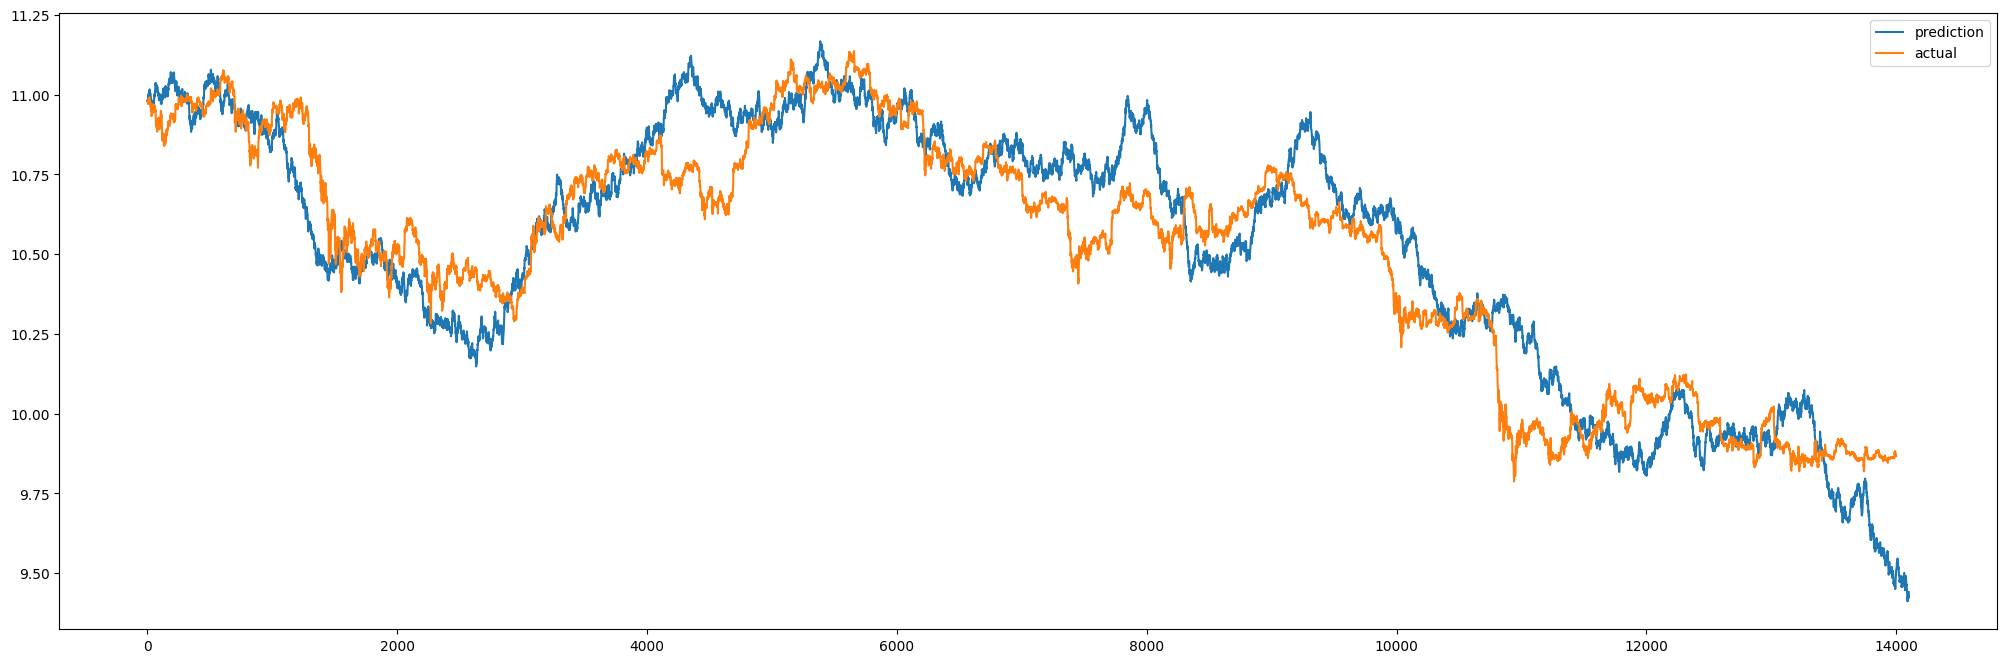

In [56]:
returns = predict(mean=prior_log_mean, std=prior_log_std, size=len(df)+100, seed=best_seed)
prediction = apply_returns(start, returns)
compare(prediction, latest_log_prices.values)
#compare(prediction, log_prices.values)